In [1]:
import torch
from tqdm import tqdm

In [1]:
import json
import pandas as pd
import dataset_util

[nltk_data] Downloading package punkt to
[nltk_data]     /home/user/welzs0/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/user/welzs0/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/user/welzs0/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Load Datasets

In [2]:
rest_train = dataset_util.load_dataset(split="train", domain="rest") + dataset_util.load_dataset(split="dev", domain = "rest")
rest_test = dataset_util.load_dataset(split="test", domain="rest")
laptop_train = dataset_util.load_dataset(split="train", domain="laptop") + dataset_util.load_dataset(split="dev", domain = "laptop")
laptop_test = dataset_util.load_dataset(split="test", domain="laptop")

## Preprocess

In [3]:
dataset_util.clean_dataset(rest_train)
dataset_util.clean_dataset(laptop_train)
dataset_util.clean_dataset(rest_test)
dataset_util.clean_dataset(laptop_test)

Processing Text: 100%|████████████████████████████████████████████████████████████| 638/638 [00:00<00:00, 130554.03it/s]


In [12]:
rest_train = remove_duplicates(rest_train)
rest_test = remove_duplicates(rest_test)
laptop_train = remove_duplicates(laptop_train)
laptop_test = remove_duplicates(laptop_test)

Test if any duplicates are left in the datasets. (Should/Must be False)

In [13]:
print(check_duplicate(rest_test))

False


## Some DataAugmentation for imbalanced classes



### Some examples for augmented sentences

In [14]:
from nlpaug.augmenter.word.context_word_embs import ContextualWordEmbsAug
aug = ContextualWordEmbsAug(action='insert',model_path='roberta-base')
sentence = rest_train[90]['sentence']
augmented_data = aug.augment(sentence, n = 2)
print(f"Original Data: {sentence}")
print(f"Augmented Data: {augmented_data}")

Original Data: great food good size menu great service and an unpretensious setting
Augmented Data: ['great food good small size small menu great service atmosphere and atmosphere an excellent unpretensious setting', 'great overall food experience good sample size menu experience great service and an unpretensious office setting']


In [36]:
from nlpaug.augmenter.word.split import SplitAug
aug = SplitAug()
sentence = rest_train[90]['sentence']
augmented_data = aug.augment(sentence, n = 2)
print(f"Original Data: {sentence}")
print(f"Augmented Data: {augmented_data}")

Original Data: great food good size menu great service and an unpretensious setting
Augmented Data: ['gre at food good size m enu great se rvice and an unpretensious set ting', 'g reat f ood good size menu great ser vice and an unpretensious set ting']


In [37]:
from nlpaug.augmenter.word.synonym import SynonymAug
aug = SynonymAug()
augmented_data = aug.augment(rest_train[90]['sentence'], n=2)
print(f"Original Data: {rest_train[90]['sentence']}")
print(f"Augmented Data: {augmented_data}")

Original Data: great food good size menu great service and an unpretensious setting
Augmented Data: ['great food for thought undecomposed sizing fare great service and an unpretensious setting', 'great food good size carte du jour great armed service and an unpretensious circumstance']


In [38]:
from nlpaug.augmenter.word.back_translation import BackTranslationAug
aug = BackTranslationAug(from_model_name='Helsinki-NLP/opus-mt-en-zh', to_model_name='Helsinki-NLP/opus-mt-zh-en')
augmented_data = aug.augment(rest_train[61]['sentence'])
print(f"Original Data: {rest_train[61]['sentence']} | Polarity: {rest_train[61]['polarity']}")
print(f"Augmented Data: {augmented_data}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Original Data: the prices are about for an entree for dinner and even less for lunch | Polarity: positive
Augmented Data: ['The price of dinner and lunch is lower than that.']


In [39]:
from nlpaug.augmenter.word.random import RandomWordAug
aug = RandomWordAug(action='swap')
augmented_data = aug.augment(rest_train[61]['sentence'])
print(f"Original Data: {rest_train[61]['sentence']} | Polarity: {rest_train[61]['polarity']}")
print(f"Augmented Data: {augmented_data}")

Original Data: the prices are about for an entree for dinner and even less for lunch | Polarity: positive
Augmented Data: ['the about prices are an for entree dinner for and less even for lunch']


### Data augmentation for datasets

Augment the traing data.

In [5]:
rest_train_augmented = rest_train#dataset_util.augment_dataset(rest_train, negative_neutral_polarities={'negative','neutral'}, probabilities=[0, 0, 0, 1])

In [6]:
laptop_train_augmented = laptop_train#dataset_util.augment_dataset(laptop_train, negative_neutral_polarities={'neutral'}, probabilities=[0, 0, 0, 1])

#### Number of instances for each sentiment after augmentation.

In [7]:
pos = 0
neg = 0
neu = 0
for item in laptop_train_augmented:
    polarity = item['polarity']
    if polarity == 'positive':
        pos += 1
    elif polarity == 'negative':
        neg += 1
    elif polarity == 'neutral':
        neu += 1
print(f"Positive : {pos}")
print(f"Negative : {neg}")
print(f"Neutral : {neu}")

print(f"Total: {len(laptop_train_augmented)}")

Positive : 987
Negative : 866
Neutral : 460
Total: 2313


## Add Aspects

Aspects are added to the sentence of an instance by prepending it to the sentence. The sentence and aspect are seperated by [SEP].

In [8]:
rest_train_sentences = [item['term'] + ' [SEP] ' + item['sentence'] for item in rest_train_augmented]
laptop_train_sentences = [item['term'] + ' [SEP] ' + item['sentence'] for item in laptop_train_augmented]

rest_test_sentences = [item['term'] + ' [SEP] ' + item['sentence'] for item in rest_test]
laptop_test_sentences = [item['term'] + ' [SEP] ' + item['sentence'] for item in laptop_test]

In [9]:
#rest_train_sentences = [" ".join(item['sentence']) for item in rest_train]
rest_train_polarities = [item['polarity'] for item in rest_train_augmented]

#rest_test_sentences = [" ".join(item['sentence']) for item in rest_test]
rest_test_polarities = [item['polarity'] for item in rest_test]


#laptop_train_sentences = [" ".join(item['sentence']) for item in laptop_train]
laptop_train_polarities = [item['polarity'] for item in laptop_train_augmented]

#laptop_test_sentences = [" ".join(item['sentence']) for item in laptop_test]
laptop_test_polarities = [item['polarity'] for item in laptop_test]

Example input from the restaurant data with the given polarity.

In [10]:
import random
random_index = random.randint(0, len(rest_train_sentences))
random_sentence = rest_train_sentences[random_index]
random_polarity = rest_train_polarities[random_index]
print(random_sentence)
print(random_polarity)

prix fixe meal [SEP] could be pricey without a prix fixe meal
negative


#### Encode the polarity labels for all datasets.

In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
rest_y_train = label_encoder.fit_transform(rest_train_polarities)
rest_y_test = label_encoder.transform(rest_test_polarities)

laptop_y_train = label_encoder.fit_transform(laptop_train_polarities)
laptop_y_test = label_encoder.transform(laptop_test_polarities)

## Define Model (Deberta)

Models are defined by importing them from hugging face. Additionally Tokenizer are imported and used.

In [12]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset

model_name = 'microsoft/deberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def encode_sentences(sentences, max_length=128):
    input_ids = []
    attention_masks = []

    for sentence in sentences:
        encoded_dict = tokenizer.encode_plus(
                            sentence,                      # Sentence to encode
                            add_special_tokens=True,       # Add '[CLS]' and '[SEP]'
                            max_length=max_length,         # Pad & truncate all sentences
                            padding='max_length',          # Pad all sentences to max length
                            truncation=True,               # Explicitly truncate to max length
                            return_attention_mask=True,    # Construct attention masks
                            return_tensors='pt',           # Return pytorch tensors
                        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)


# Encode the sentences (X_train and X_test)
rest_train_inputs, rest_train_masks = encode_sentences(rest_train_sentences)
rest_test_inputs, rest_test_masks = encode_sentences(rest_test_sentences)

laptop_train_inputs, laptop_train_masks = encode_sentences(laptop_train_sentences)
laptop_test_inputs, laptop_test_masks = encode_sentences(laptop_test_sentences)

Create torch tensors from the encoded label vectors, to be able to use them with the model and with the encoded sentences.

In [31]:
rest_train_labels = torch.tensor(rest_y_train)
rest_test_labels = torch.tensor(rest_y_test)

laptop_train_labels = torch.tensor(laptop_y_train)
laptop_test_labels = torch.tensor(laptop_y_test)

Define dataset class to be able to load instances (with given batch size) for the training. Custom Dataset that stores the original sentences such that we can see which sentences were predicted wrong and which were correct.

In [55]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, inputs, masks, labels, original_sentences):
        self.inputs = inputs
        self.masks = masks
        self.labels = labels
        self.original_sentences = original_sentences

    def __len__(self):
        return len(self.original_sentences)

    def __getitem__(self, idx):
        input = self.inputs[idx] 
        mask = self.masks[idx]
        label = self.labels[idx]
        original_sentence = self.original_sentences[idx]  # Storing the original sentence
        return input, mask, label, original_sentence

Initialize all datasets and dataloader for the training/testing process.

In [56]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 16  # Adjust this according to your GPU capacity

# Create the DataLoader for our training set
rest_train_data = TensorDataset(rest_train_inputs, rest_train_masks, rest_train_labels)
rest_train_sampler = RandomSampler(rest_train_data)
rest_train_dataloader = DataLoader(rest_train_data, sampler=rest_train_sampler, batch_size=batch_size) 

# Create the DataLoader for our test set
rest_test_data = MyDataset(rest_test_inputs, rest_test_masks, rest_test_labels, rest_test_sentences)
rest_test_sampler = SequentialSampler(rest_test_data)
rest_test_dataloader = DataLoader(rest_test_data, sampler=rest_test_sampler, batch_size=batch_size)

# Create the DataLoader for our training set
laptop_train_data = TensorDataset(laptop_train_inputs, laptop_train_masks, laptop_train_labels)
laptop_train_sampler = RandomSampler(laptop_train_data)
laptop_train_dataloader = DataLoader(laptop_train_data, sampler=laptop_train_sampler, batch_size=batch_size) 

# Create the DataLoader for our test set
laptop_test_data = MyDataset(laptop_test_inputs, laptop_test_masks, laptop_test_labels, laptop_test_sentences)
laptop_test_sampler = SequentialSampler(laptop_test_data)
laptop_test_dataloader = DataLoader(laptop_test_data, sampler=laptop_test_sampler, batch_size=batch_size)

In [33]:
# Initializing a DeBERTa-v2 microsoft/deberta-v2-xlarge style configuration
#configuration = DebertaV2Config()
import torch.nn as nn
# Initializing a model (with random weights) from the microsoft/deberta-v2-xlarge style configuration
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 3) # 3 polarities
# Tell the model to run on GPU
model.to(device)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'pooler.dense.weight', 'pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaForSequenceClassification(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0): DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
          (intermed

Set training parameters/functions to the wanted values/objects.
We train for 15 epochs, use the optimizer adamw and use an exponential learning rate scheduler.

In [29]:
from transformers import get_linear_schedule_with_warmup, get_constant_schedule_with_warmup, get_cosine_schedule_with_warmup
import torch.optim as optim
import torch
# Implement the training loop
epochs = 15

# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps = 1e-8)

# Total number of training steps
total_steps = len(train_dataloader) * epochs

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# Create the learning rate scheduler.

### Training function and stats during training

In [31]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import numpy as np
best_accuracy = 0
validation_acc = []
validation_prec = []
validation_f1 = []
validation_recall = []
validation_loss = []
training_loss = []
training_progress = []
for epoch in range(0, epochs):
    # Training step
    model.train()
    total_train_loss = 0
    progress_bar = tqdm(train_dataloader, desc="Epoch {:1d}".format(epoch+1), leave=False, disable=False)
    for batch in progress_bar:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear previously calculated gradients
        model.zero_grad()        
        # Perform a forward pass
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        training_progress.append(loss.item())

        # Perform a backward pass
        loss.backward()

        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # Update the progress bar
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
    
    # Calculate the average loss over the training data.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    print(f"  Average training loss: {avg_train_loss:.2f}")
    training_loss.append(avg_train_loss)
    
    model.eval()

    # Initialize variables to gather predictions and true labels
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        total_eval_loss = 0
        for batch in tqdm(test_dataloader):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            #token_type_ids = None
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)

            loss = outputs.loss
            total_eval_loss += loss.item()

            logits = outputs.logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Store predictions and true labels
            all_predictions.extend(np.argmax(logits, axis=1).flatten())
            all_true_labels.extend(label_ids.flatten())
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predictions, average='weighted')
    accuracy = accuracy_score(all_true_labels, all_predictions)
    avg_test_loss = total_eval_loss / len(test_dataloader)
    
    scheduler.step(accuracy)
    
    validation_acc.append(accuracy)
    validation_prec.append(precision)
    validation_f1.append(f1_score)
    validation_recall.append(recall)
    validation_loss.append(avg_test_loss)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1_score:.4f}')
    if accuracy >= best_accuracy:
        print(f"  Accuracy increased to {accuracy:.2f} from {best_accuracy:.2f}, saving model.")
        best_accuracy = accuracy
        best_model_state = model.state_dict()
        torch.save(best_model_state, 'DeBERTa_Laptop.bin')

  Average training loss: 0.63


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 28.01it/s]


Accuracy: 0.7724
Precision: 0.7806
Recall: 0.7724
F1-Score: 0.7676
  Accuracy increased to 0.77 from 0.00, saving model.


  Average training loss: 0.40


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.76it/s]


Accuracy: 0.7548
Precision: 0.7945
Recall: 0.7548
F1-Score: 0.7557


  Average training loss: 0.25


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.64it/s]


Accuracy: 0.7853
Precision: 0.7793
Recall: 0.7853
F1-Score: 0.7802
  Accuracy increased to 0.79 from 0.77, saving model.


  Average training loss: 0.17


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.53it/s]


Accuracy: 0.8109
Precision: 0.8261
Recall: 0.8109
F1-Score: 0.8150
  Accuracy increased to 0.81 from 0.79, saving model.


  Average training loss: 0.12


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.43it/s]


Accuracy: 0.7692
Precision: 0.7641
Recall: 0.7692
F1-Score: 0.7515


  Average training loss: 0.08


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.18it/s]


Accuracy: 0.8013
Precision: 0.8050
Recall: 0.8013
F1-Score: 0.8023


  Average training loss: 0.06


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.09it/s]


Accuracy: 0.7933
Precision: 0.8015
Recall: 0.7933
F1-Score: 0.7908


  Average training loss: 0.06


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.02it/s]


Accuracy: 0.8061
Precision: 0.8073
Recall: 0.8061
F1-Score: 0.8060


  Average training loss: 0.07


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 26.99it/s]


Accuracy: 0.8045
Precision: 0.8138
Recall: 0.8045
F1-Score: 0.8028


  Average training loss: 0.03


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.04it/s]


Accuracy: 0.7917
Precision: 0.7982
Recall: 0.7917
F1-Score: 0.7877


  Average training loss: 0.03


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.05it/s]


Accuracy: 0.8061
Precision: 0.8210
Recall: 0.8061
F1-Score: 0.8039


  Average training loss: 0.01


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.05it/s]


Accuracy: 0.7981
Precision: 0.8232
Recall: 0.7981
F1-Score: 0.7987


  Average training loss: 0.02


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.12it/s]


Accuracy: 0.8029
Precision: 0.8166
Recall: 0.8029
F1-Score: 0.7929


  Average training loss: 0.01


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.11it/s]


Accuracy: 0.7949
Precision: 0.8025
Recall: 0.7949
F1-Score: 0.7870


  Average training loss: 0.03


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.19it/s]

Accuracy: 0.7869
Precision: 0.8114
Recall: 0.7869
F1-Score: 0.7760


#### Plot loss curves and other metrics from the training

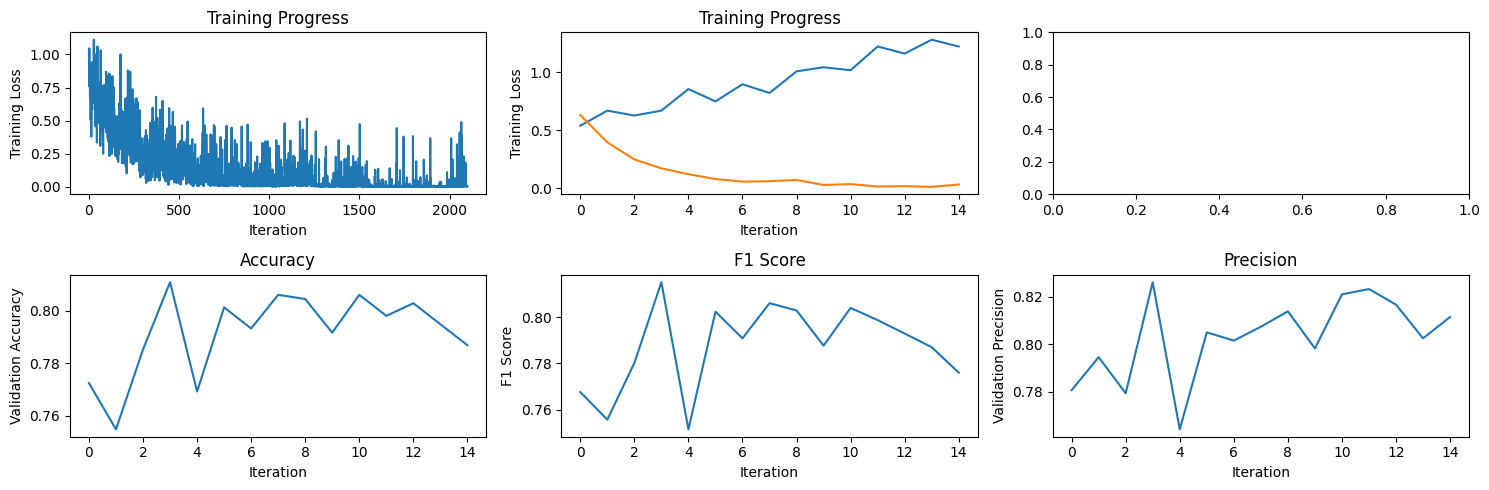

In [32]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 3, figsize=(15,5))

axs[0, 0].plot(training_progress)
axs[0, 0].set_title("Training Progress")
axs[0, 0].set_xlabel("Iteration")
axs[0, 0].set_ylabel("Training Loss")

axs[0, 1].plot(validation_loss)
axs[0, 1].plot(training_loss)
axs[0, 1].set_title("Training Progress")
axs[0, 1].set_xlabel("Iteration")
axs[0, 1].set_ylabel("Training Loss")

axs[1, 1].plot(validation_f1)
axs[1, 1].set_title("F1 Score")
axs[1, 1].set_xlabel("Iteration")
axs[1, 1].set_ylabel("F1 Score")

axs[1, 0].plot(validation_acc)
axs[1, 0].set_title("Accuracy")
axs[1, 0].set_xlabel("Iteration")
axs[1, 0].set_ylabel("Validation Accuracy")

axs[1, 2].plot(validation_prec)
axs[1, 2].set_title("Precision")
axs[1, 2].set_xlabel("Iteration")
axs[1, 2].set_ylabel("Validation Precision")


plt.tight_layout()
plt.show()

# Evaluation

## Evaluation Restaurant

We evaluate with precision, recall, accuracy and $F_1$-score.
Additionally we show some example sentences together with their original(ground truth) and predicted sentiment.

In [64]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import numpy as np
model_name = 'microsoft/deberta-base'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 3)
#Load best Model
model = model.to(device)
model.load_state_dict(torch.load('model_checkpoints/DeBERTa_Restaurant_augmented.bin'))

model.eval()
# Initialize variables to gather predictions and true labels
all_predictions = []
all_true_labels = []

misclassified_sentences = []
correctlyclassified_sentences = []

with torch.no_grad():
    total_eval_loss = 0
    for batch in tqdm(rest_test_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_original_sentence = batch[3]
        #token_type_ids = None
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        predictions = np.argmax(logits, axis=1)
        for sentence, prediction, actual_label in zip(b_original_sentence, predictions, label_ids):
            if prediction != actual_label:
                misclassified_sentences.append((sentence, prediction, actual_label))
            else:
                correctlyclassified_sentences.append((sentence, prediction, actual_label))
        
        # Store predictions and true labels
        all_predictions.extend(predictions.flatten())
        all_true_labels.extend(label_ids.flatten())
precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predictions, average='weighted')
accuracy = accuracy_score(all_true_labels, all_predictions)
avg_test_loss = total_eval_loss / len(rest_test_dataloader)

conf_matrix_rest = confusion_matrix(all_true_labels, all_predictions)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1_score:.4f}')

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'pooler.dense.weight', 'pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 29.09it/s]

Accuracy: 0.8854
Precision: 0.8834
Recall: 0.8854
F1-Score: 0.8795


#### Sample sentences from the restaurant dataset 

##### sentences that were miss classified

In [63]:
for sentence, prediction, label in misclassified_sentences[:20]:
    print(f"{sentence}")
    print(f"Prediction {label_encoder.classes_[prediction]} | Actual Label {label_encoder.classes_[label]}\n")

quality of food [SEP] the service however is a peg or two below the quality of food horrible bartenders and the clientele for the most part are rowdy loudmouthed commuters this could explain the bad attitudes from the staff getting loaded for an acdc concert or a knicks game
Prediction negative | Actual Label positive

cake [SEP] the icing made this cake it was fluffy not ultra sweet creamy and light
Prediction negative | Actual Label positive

sauce [SEP] perfectly al dente pasta not drowned in sauce generous portions
Prediction negative | Actual Label neutral

dessert pizza [SEP] while theres a decent menu it shouldnt take ten minutes to get your drinks and for a dessert pizza
Prediction positive | Actual Label neutral

served [SEP] they are served on focacchia bread and are to die for
Prediction negative | Actual Label neutral

waitress [SEP] when she complained the waitress said sorry
Prediction negative | Actual Label neutral

french dish [SEP] good place to hang out during the da

##### Sentences that are classified correctly

In [65]:
for sentence, prediction, label in correctlyclassified_sentences[:20]:
    print(f"{sentence}")
    print(f"Prediction {label_encoder.classes_[prediction]} | Actual Label {label_encoder.classes_[label]}\n")

calamari [SEP] for an appetizer their calamari is a winner
Prediction positive | Actual Label positive

service [SEP] the service is excellent and always informative without an air
Prediction positive | Actual Label positive

blue bar area [SEP] dug the blue bar area too
Prediction positive | Actual Label positive

back patio [SEP] have a mojito and sit in the back patio
Prediction positive | Actual Label positive

salmon dishes [SEP] i recommend any of their salmon dishes
Prediction positive | Actual Label positive

slices [SEP] finally let into the store at a time to buy expensive slices from a harried staff
Prediction negative | Actual Label negative

staff [SEP] finally let into the store at a time to buy expensive slices from a harried staff
Prediction negative | Actual Label negative

food [SEP] i thought the food isnt cheap at all compared to chinatown
Prediction negative | Actual Label negative

service [SEP] the service however is a peg or two below the quality of food horribl

## Evaluation Laptop

Same as the evaluation for the restaurant dataset above.

In [58]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import numpy as np
model_name = 'microsoft/deberta-base'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 3)
#Load best Model
model = model.to(device)
model.load_state_dict(torch.load('model_checkpoints/DeBERTa_Laptop_augmented.bin'))

model.eval()
# Initialize variables to gather predictions and true labels
all_predictions = []
all_true_labels = []

with torch.no_grad():
    total_eval_loss = 0
    for batch in tqdm(laptop_test_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        #token_type_ids = None
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        all_predictions.extend(np.argmax(logits, axis=1).flatten())
        all_true_labels.extend(label_ids.flatten())
precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predictions, average='weighted')
accuracy = accuracy_score(all_true_labels, all_predictions)
avg_test_loss = total_eval_loss / len(laptop_test_dataloader)

conf_matrix_laptop = confusion_matrix(all_true_labels, all_predictions)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1_score:.4f}')

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'pooler.dense.weight', 'pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 29.24it/s]

Accuracy: 0.8173
Precision: 0.8221
Recall: 0.8173
F1-Score: 0.8171


#### Further results for each dataset split up for each sentiment.

##### Confusion matrix

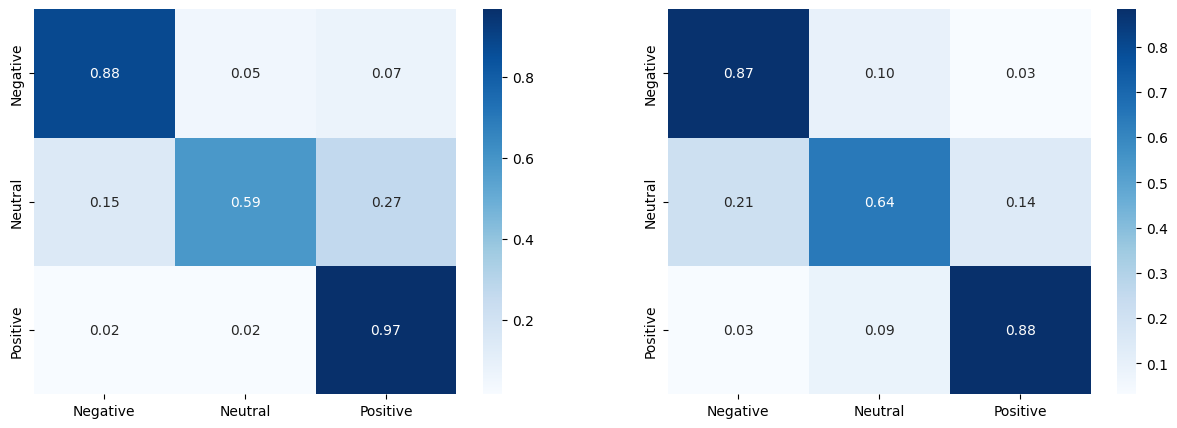

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix_rest = conf_matrix_rest.astype('float') / conf_matrix_rest.sum(axis=1)[:, np.newaxis]
conf_matrix_laptop = conf_matrix_laptop.astype('float') / conf_matrix_laptop.sum(axis=1)[:, np.newaxis]

fig, axs = plt.subplots(1, 2, figsize=(15,5))


sns.heatmap(conf_matrix_rest, annot=True, ax=axs[0], xticklabels = ["Negative", "Neutral", "Positive"], yticklabels = ["Negative", "Neutral", "Positive"]
           , fmt='.2f', cmap='Blues',)
sns.heatmap(conf_matrix_laptop, annot=True, ax=axs[1], xticklabels = ["Negative", "Neutral", "Positive"], yticklabels = ["Negative", "Neutral", "Positive"]
           , fmt='.2f', cmap='Blues')
axs[0].spines['top'].set_visible=(True)
axs[0].spines['right'].set_visible=(True)

axs[1].spines['top'].set_visible=(True)
axs[1].spines['right'].set_visible=(True)
plt.show()

##### precision, recall, $F_1$score, accuracy for each sentiment.

###### Resutls for the restaurant dataset

In [45]:
conf_matrix = conf_matrix_rest
# Negative
TP = conf_matrix[0,0]
FP = sum(conf_matrix[:, 0]) - TP
FN = sum(conf_matrix[0, :]) - TP

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)
print("------------------Negative--------------------")
print(f"Precision Negative: {precision}")
print(f"Recall Negative: {recall}")
print(f"F1 Score Negative: {f1}")

# Neutral
TP = conf_matrix[1,1]
FP = sum(conf_matrix[:, 1]) - TP
FN = sum(conf_matrix[1, :]) - TP

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)
print("------------------Neutral--------------------")
print(f"Precision Neutral: {precision}")
print(f"Recall Neutral: {recall}")
print(f"F1 Score Neutral: {f1}")

# Positive
TP = conf_matrix[2,2]
FP = sum(conf_matrix[:, 2]) - TP
FN = sum(conf_matrix[2, :]) - TP

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)
print("------------------Positive--------------------")
print(f"Precision Positive: {precision}")
print(f"Recall Positive: {recall}")
print(f"F1 Score Positive: {f1}")

------------------Negative--------------------
Precision Negative: 0.8075117370892019
Recall Negative: 0.8775510204081632
F1 Score Negative: 0.8410757946210269
------------------Neutral--------------------
Precision Neutral: 0.8455882352941176
Recall Neutral: 0.5867346938775511
F1 Score Neutral: 0.6927710843373495
------------------Positive--------------------
Precision Positive: 0.9140625
Recall Positive: 0.9682758620689655
F1 Score Positive: 0.9403884795713329


###### results for the laptop dataset

In [46]:
conf_matrix = conf_matrix_laptop
# Negative
TP = conf_matrix[0,0]
FP = sum(conf_matrix[:, 0]) - TP
FN = sum(conf_matrix[0, :]) - TP

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)
print("------------------Negative--------------------")
print(f"Precision Negative: {precision}")
print(f"Recall Negative: {recall}")
print(f"F1 Score Negative: {f1}")

# Neutral
TP = conf_matrix[1,1]
FP = sum(conf_matrix[:, 1]) - TP
FN = sum(conf_matrix[1, :]) - TP

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)
print("------------------Neutral--------------------")
print(f"Precision Neutral: {precision}")
print(f"Recall Neutral: {recall}")
print(f"F1 Score Neutral: {f1}")

# Positive
TP = conf_matrix[2,2]
FP = sum(conf_matrix[:, 2]) - TP
FN = sum(conf_matrix[2, :]) - TP

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)
print("------------------Positive--------------------")
print(f"Precision Positive: {precision}")
print(f"Recall Positive: {recall}")
print(f"F1 Score Positive: {f1}")

------------------Negative--------------------
Precision Negative: 0.7006369426751592
Recall Negative: 0.873015873015873
F1 Score Negative: 0.7773851590106008
------------------Neutral--------------------
Precision Neutral: 0.7266666666666667
Recall Neutral: 0.6449704142011834
F1 Score Neutral: 0.6833855799373041
------------------Positive--------------------
Precision Positive: 0.9146341463414634
Recall Positive: 0.8823529411764706
F1 Score Positive: 0.8982035928143712
